# GAN

In [1]:
# train a generative adversarial network on a one-dimensional function
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow
tensorflow.test.gpu_device_name()

%matplotlib inline
import matplotlib.pyplot as plt
import numpy
# example of defining the generator model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import BatchNormalization

import tensorflow
tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)

## Dataset

In [2]:
import scipy.io
# load phase dateset
def load_real_samples():
    d = scipy.io.loadmat('dataset')
    data_X = d['data_X']
    data_Y = d['data_Y'].ravel()
    
    #class abundances
    #print('N:', sum((data_Y == 0).ravel()))
    #print('S:', sum((data_Y == 1).ravel()))
    #print('P:', sum((data_Y == 2).ravel()))
    #print('T:', sum((data_Y == 3).ravel()))
    
    P_phase_indices = (data_Y == 2)
    X = data_X[P_phase_indices]
    
    means_in_channels = numpy.mean(X, axis=1, keepdims=True)
    X -= means_in_channels
    
    max_in_channels = numpy.max(numpy.max(numpy.abs(X), axis=1, keepdims=True), axis=2, keepdims=True)
    
    X /= max_in_channels
    
    return X, means_in_channels, max_in_channels

(6364, 400, 3)


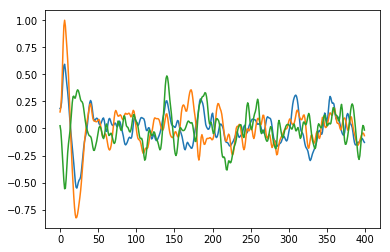

In [3]:
dataset, _, max_in_channels = load_real_samples()
SAMPLES = dataset.shape[1]
CHANNELS = dataset.shape[2]
print(dataset.shape)
plt.plot(dataset[1006])


(6364,)
(5751,)


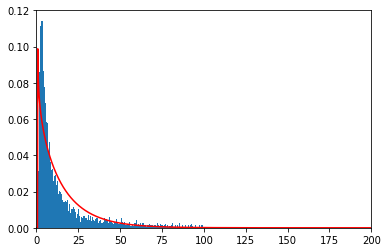

array([ 1.83850907])

In [4]:
maxs = max_in_channels[:,0,0]
print(maxs.shape)
maxs = maxs[maxs<100]
print(maxs.shape)

import scipy.stats as stats
fit_alpha, fit_loc, fit_beta = stats.gamma.fit(maxs)


fig = plt.figure()
ax = fig.add_subplot(111)
_,_,_ = ax.hist(maxs, bins=200, density=1)
x = numpy.linspace(0,200,1000)
ax.plot(x, stats.gamma.pdf(x, fit_alpha, fit_loc, fit_beta), color='r')
ax.set_xlim(0,200)
plt.show()


def get_amplitude(alpha=fit_alpha, loc=fit_loc, beta=fit_beta):
    return stats.gamma.rvs(alpha, loc=loc, scale=beta, size=1)

get_amplitude()

# Conv1D GAN

In [5]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = numpy.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X = numpy.reshape(X, (n_samples, SAMPLES, CHANNELS))
    # generate 'real' class labels (1)
    y = numpy.ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = numpy.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = numpy.zeros((n_samples, 1))
    return X, y


# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    DWNSMPLD = 100
    # foundation for 100 samples (downsampled 400 samples) x 3 channels
    n_nodes = 256 * DWNSMPLD # 128 is number of possible realizations   #100 is here 400 downsampled!!!
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((DWNSMPLD, 256)))
    # upsample to 200
    #model.add(Conv2DTranspose(128, (4,), strides=(2,), padding='same'))
    model.add(UpSampling1D())
    model.add(Conv1D(128, (3,), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 400
    #model.add(Conv2DTranspose(128, (4,), strides=(2,), padding='same'))
    model.add(UpSampling1D())
    model.add(Conv1D(128, (7,), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv1D(3, (11,), activation='tanh', padding='same'))
    
    #model.add(Reshape((SAMPLES, CHANNELS)))
    
    return model


# define the standalone discriminator model
def define_discriminator(in_shape=(SAMPLES, CHANNELS)):
    model = Sequential()
    model.add(Conv1D(64, (3,), strides=(2,), padding='same', input_shape=in_shape))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Conv1D(64, (5,), strides=(2,), padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model    
    

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
    

#test of models
print('Generator:')
g_model = define_generator(100)
print(g_model.summary())

print()
print('Discriminator:')
d_model = define_discriminator(in_shape=(SAMPLES, CHANNELS))
print(d_model.summary())

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25600)             2585600   
_________________________________________________________________
batch_normalization (BatchNo (None, 25600)             102400    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 25600)             0         
_________________________________________________________________
reshape (Reshape)            (None, 100, 256)          0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 200, 256)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 128)          98432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 128)          512       

In [6]:
def visual_eval_generator(g_model, n_samples=10, real=False):
    if not real:
        X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    else:
        X, _ = generate_real_samples(dataset, n_samples)
        
    fig = plt.figure(figsize=(8,16))
    for i in range(n_samples):
        amp = get_amplitude()
        ax = fig.add_subplot(n_samples, 1, i+1)
        ax.plot(X[i, :, 0]*amp,label='E')
        ax.plot(X[i, :, 1]*amp,label='N')
        ax.plot(X[i, :, 2]*amp,label='Z')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
LABEL_SMOOTH = 1.0

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            y_real *= LABEL_SMOOTH
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator           
            X, y = numpy.vstack((X_real, X_fake)), numpy.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = numpy.ones((n_batch, 1)) * LABEL_SMOOTH
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            #print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        #if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [8]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

>Accuracy real: 0%, fake: 85%
>Accuracy real: 3%, fake: 100%
>Accuracy real: 49%, fake: 100%
>Accuracy real: 70%, fake: 100%
>Accuracy real: 66%, fake: 80%
>Accuracy real: 67%, fake: 7%
>Accuracy real: 45%, fake: 100%
>Accuracy real: 66%, fake: 0%
>Accuracy real: 35%, fake: 0%
>Accuracy real: 63%, fake: 0%
>Accuracy real: 61%, fake: 1%
>Accuracy real: 35%, fake: 63%
>Accuracy real: 73%, fake: 4%
>Accuracy real: 51%, fake: 84%
>Accuracy real: 36%, fake: 0%
>Accuracy real: 36%, fake: 7%
>Accuracy real: 62%, fake: 20%
>Accuracy real: 61%, fake: 67%
>Accuracy real: 29%, fake: 100%
>Accuracy real: 70%, fake: 0%
>Accuracy real: 56%, fake: 0%
>Accuracy real: 41%, fake: 2%
>Accuracy real: 32%, fake: 77%
>Accuracy real: 67%, fake: 19%
>Accuracy real: 50%, fake: 62%
>Accuracy real: 71%, fake: 100%
>Accuracy real: 65%, fake: 99%
>Accuracy real: 62%, fake: 1%
>Accuracy real: 17%, fake: 72%
>Accuracy real: 52%, fake: 46%


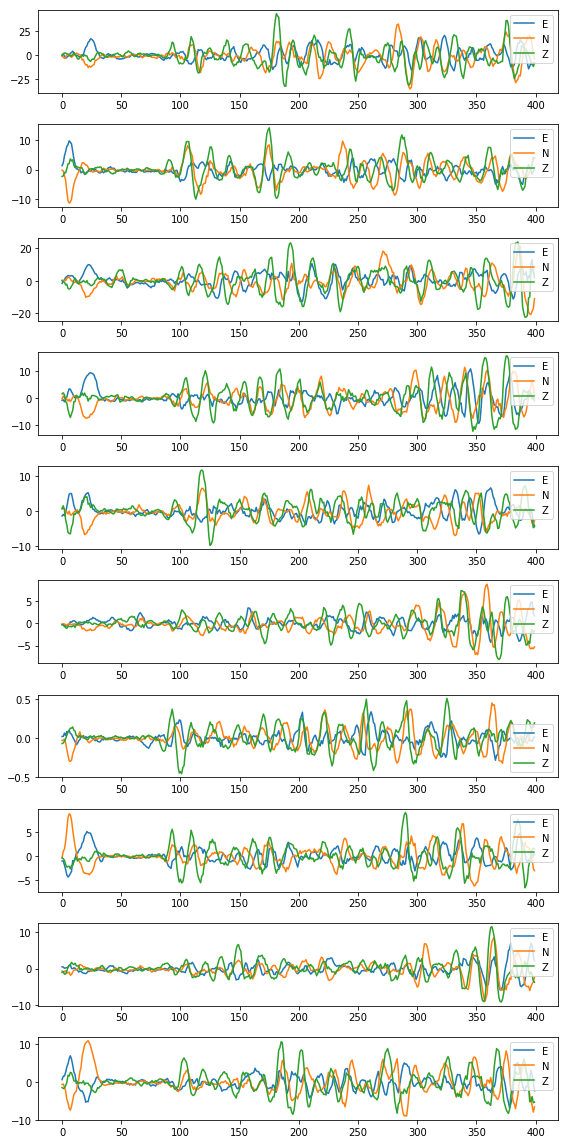

In [9]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30)
visual_eval_generator(g_model)

# True samples

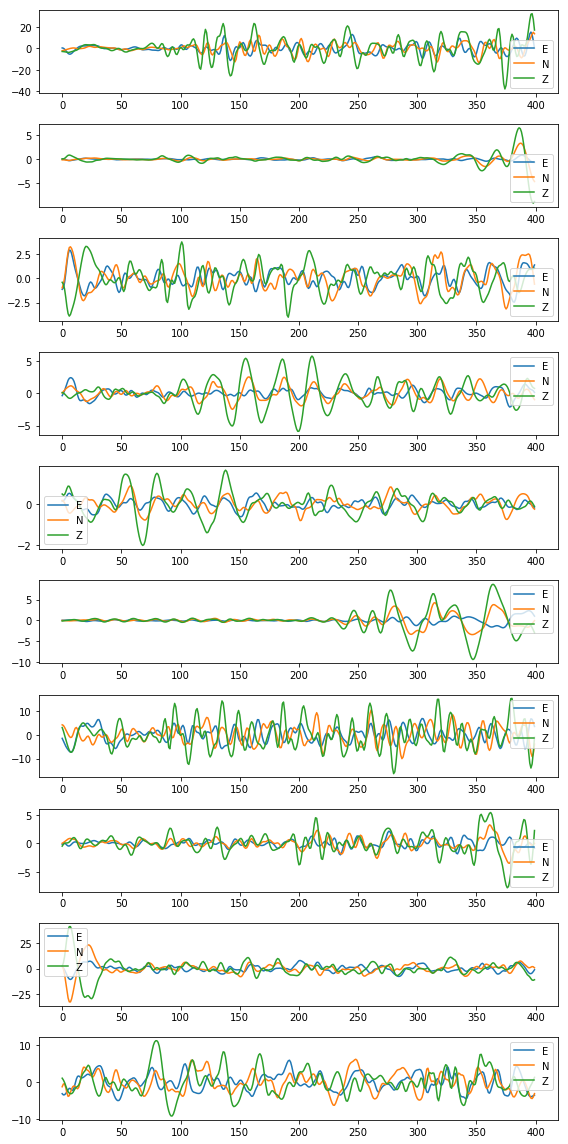

In [10]:
visual_eval_generator(g_model, n_samples=10, real=True)